In [46]:
# IMPORT LIBRARIES AND NOISE DATA FILE
import csv, glob, os, sys, numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import timeit
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy import signal
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly
from theano.tensor.signal.pool import pool_2d
from sknn.mlp import Regressor, Layer
from sklearn.preprocessing import StandardScaler 
from scipy import stats; from sklearn import preprocessing
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from timeit import default_timer as timer
from sklearn.model_selection import KFold

def MSE(y,y0): #create mean-square error function to calculate ANN performance
    if len(y.shape) > 1:
        y = np.squeeze(y)
    if len(y0.shape) > 1:
        y0 = np.squeeze(y0)
    return (np.average((y - y0)**2))/np.average(y)*100


plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15 #make size of axis tick labels larger

#################################################################
noisefile = 'C:\\Users\\a6q\\Desktop\\CorrEL noise measurements\\2017-09-05 ta wire noise h2o steps.txt' #CorrEl NOISE filename
sdline1, sdline2 = 14,49 #lines to start and stop import of standard deviation data
#################################################################
sddata = pd.read_table(noisefile, skiprows=sdline1, error_bad_lines=False, sep='\s+') #read in file
sddata = sddata[:sdline2].apply(pd.to_numeric, errors='coerce') #str to flt, coerce to NaN, and erase past st. dev. data
print(sddata)

b'Skipping line 3202: expected 5 fields, saw 7\n'


       time         /             s  volt.noise/V  curr.noise/A
0       0.0  0.000003  8.060000e-09           NaN           NaN
1    1000.0  0.000003  7.850000e-09           NaN           NaN
2    2000.0  0.000003  8.280000e-09           NaN           NaN
3    3000.0  0.000003  7.830000e-09           NaN           NaN
4    4000.0  0.000003  7.570000e-09           NaN           NaN
5    5000.0  0.000003  7.630000e-09           NaN           NaN
6    6000.0  0.000004  7.540000e-09           NaN           NaN
7    7000.0  0.000004  7.680000e-09           NaN           NaN
8    8000.0  0.000004  7.800000e-09           NaN           NaN
9    9000.0  0.000004  7.700000e-09           NaN           NaN
10  10000.0  0.000004  8.120000e-09           NaN           NaN
11  11000.0  0.000005  7.840000e-09           NaN           NaN
12  12000.0  0.000004  8.400000e-09           NaN           NaN
13  13000.0  0.000004  9.330000e-09           NaN           NaN
14  14000.0  0.000005  9.010000e-09     

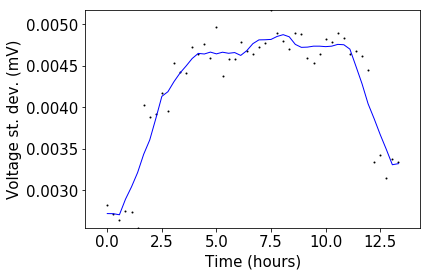

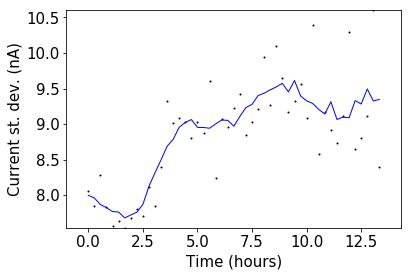

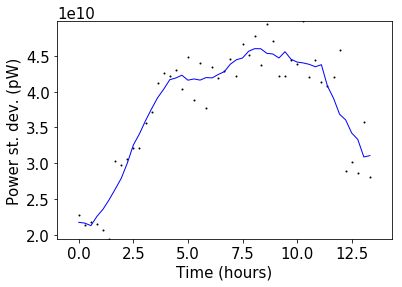

In [53]:
# ORGANIZE AND PLOT STANDARD DEVIATION VS. TIME DATA FROM NOISE FILE
sdtime = np.array(sddata['time'])/3600
sdv = np.array(sddata['/'])*1e3 #voltage in mVolts
sdi = np.array(sddata['s'])*1e9 #current in nanoAmps
sdp = np.multiply(sdv,sdi)*1e12 #power in pWatts

sdvars = [sdv, sdi, sdp] #list for sd plotting
sdlabels = ['Voltage st. dev. (mV)', 'Current st. dev. (nA)', 'Power st. dev. (pW)'] #list for y labels of plots
for i in range(len(sdvars)): #filter data for smoothing
    sdfilt = savgol_filter(sdvars[i], 7, 1, mode='mirror') #points, polynomial order, bound. cond.
    plt.plot(sdtime, sdfilt, color='b', linewidth=1) #plot filtered data
    plt.scatter(sdtime, sdvars[i], s=1, color='k') #plot raw sd data
    plt.xlabel('Time (hours)', fontsize=15); plt.ylabel(sdlabels[i], fontsize=15)
    plt.axis((min(sdtime)-1, max(sdtime)+1, min(sdvars[i]), max(sdvars[i])))
    plt.show()

In [61]:
# EXTRACT FREQUENCY DATA FROM NOISE FILE #############################################################
fline1 = sdline2 + 17  #lines to start and stop import of frequency data

#####################################################################################################
fdata0 = pd.read_table(noisefile, skiprows=fline1, header=0, error_bad_lines=False, sep='\s+') #read in file
fdata = fdata0.apply(pd.to_numeric, errors='coerce').dropna() #change from string to float, coercing to NaN 
print(fdata)

b'Skipping line 130: expected 3 fields, saw 4\nSkipping line 194: expected 3 fields, saw 4\nSkipping line 258: expected 3 fields, saw 4\nSkipping line 322: expected 3 fields, saw 4\nSkipping line 386: expected 3 fields, saw 4\nSkipping line 450: expected 3 fields, saw 4\nSkipping line 514: expected 3 fields, saw 4\nSkipping line 578: expected 3 fields, saw 4\nSkipping line 642: expected 3 fields, saw 4\nSkipping line 706: expected 3 fields, saw 4\nSkipping line 770: expected 3 fields, saw 4\nSkipping line 834: expected 3 fields, saw 4\nSkipping line 898: expected 3 fields, saw 4\nSkipping line 962: expected 3 fields, saw 4\nSkipping line 1026: expected 3 fields, saw 4\nSkipping line 1090: expected 3 fields, saw 4\nSkipping line 1154: expected 3 fields, saw 4\nSkipping line 1218: expected 3 fields, saw 4\nSkipping line 1282: expected 3 fields, saw 4\nSkipping line 1346: expected 3 fields, saw 4\nSkipping line 1410: expected 3 fields, saw 4\nSkipping line 1474: expected 3 fields, saw 4\n

      Frequency/Hz  volt.noise/V  curr.noise/A
0           0.0000  7.350000e-06  5.320000e-08
1           0.0005  7.350000e-06  5.320000e-08
2           0.0010  1.530000e-08  2.890000e-09
3           0.0015  3.850000e-08  1.680000e-09
4           0.0020  9.160000e-08  4.920000e-10
5           0.0025  4.300000e-08  9.440000e-10
6           0.0030  5.740000e-08  1.960000e-09
7           0.0035  4.570000e-08  8.050000e-10
8           0.0040  1.150000e-07  1.240000e-09
9           0.0045  1.280000e-07  1.160000e-09
10          0.0050  1.910000e-07  1.110000e-09
11          0.0055  8.070000e-08  1.250000e-09
12          0.0060  5.050000e-08  2.010000e-09
13          0.0065  7.690000e-09  1.190000e-09
14          0.0070  3.670000e-08  3.990000e-10
15          0.0075  6.410000e-08  1.660000e-10
16          0.0080  9.700000e-08  1.740000e-10
17          0.0085  9.110000e-08  4.930000e-10
18          0.0090  1.060000e-07  8.610000e-10
19          0.0095  5.570000e-08  6.370000e-10
20          0

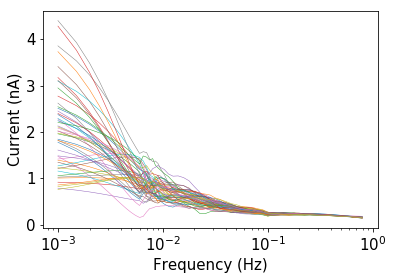

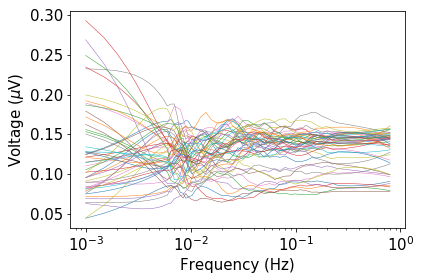

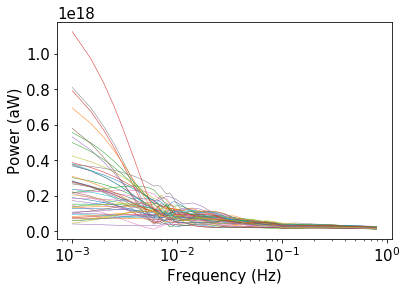

In [63]:
# PLOT FREQUENCY DOMAIN DATA
allf = np.array(fdata['Frequency/Hz']) #frequency in Hz
allv = np.array(fdata['volt.noise/V'])*1e6 #voltage in microVolts
alli = np.array(fdata['curr.noise/A'])*1e9 #current in nanoAmps
allp = np.multiply(allv, alli)*1e18 #power in attoWatts

fsweep = []; i=0
while allf[i+1] > allf[i]: fsweep.append(allf[i]); i=i+1 #find length of each freq sweep

fmat0 = np.reshape(allf, (-1,len(fsweep)+1)); imat0 = np.reshape(alli, (-1,len(fsweep)+1)) #reshape into matrices
vmat0 = np.reshape(allv, (-1,len(fsweep)+1)); pmat0 = np.reshape(allp, (-1,len(fsweep)+1))

#set starting/ending indices to remove errant points from freq. measurements############################
si, ei = 2, 2
########################################################################################################
#new empty matrices without first/last couple points
fmat = np.ones((np.shape(fmat0)[0],np.shape(fmat0)[1]-si-ei));
vmat=np.copy(fmat); imat=np.copy(fmat); pmat=np.copy(fmat); zmat=np.copy(fmat)

for i in range(len(fmat)): #create matrices without the first/last couple points
    fmat[i] = fmat0[i][si:-ei]; vmat[i] = vmat0[i][si:-ei]
    imat[i] = imat0[i][si:-ei]; pmat[i] = pmat0[i][si:-ei]
    
fvars = [imat, vmat, pmat] #make lists for looping over plots
flabels = ['Current (nA)', 'Voltage ($\mu$V)', 'Power (aW)']

for j in range(len(flabels)): #plot filtered freq-dependent noise spectra
    for i in range(len(fmat)): 
        ffilt = savgol_filter(fvars[j][i], 21, 2, mode='interp') #points, polynomial order, bound. cond.
        plt.semilogx(fmat[i],ffilt, linewidth=.5) #plot noise
    plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel(flabels[j],fontsize=15)
    plt.show()

# FIT FREQUENCY DOMAIN DATA fit noise to pink (1/f) or brown (1/f^2)
timecycle = np.arange(len(fmat))*1000/60/60 #create time array

def noisefit(f, c, n):  # define variables in each function
    return c / f**n

for k in range(len(fvars)): #loop over varibles (current, power, impedance)
    clist = []; nlist = [] #save lists of fitting parameters
    maxlist = np.array([]);
    for i in range(len(fmat)): #loop over number of timing cycles
        try:
            popt, pcov = curve_fit(noisefit, fmat[i], ffilt)# fvars[k][i]) #find fit parameters
            fit =  noisefit(fmat[i], *popt) #build fit line
            c = popt[0]; n = popt[1] #get fitting parameters from popt
            clist.append(c); nlist.append(n)
        
            plt.plot(fmat[i],fvars[k][i]) #plot fits
            plt.plot(fmat[i],fit,linewidth=1, c='k')
        
        except RuntimeError: #if error in fitting, keep going amnd assign 0 values
            clist.append(0); nlist.append(0)
            print('error in fitting column index ' + format(i))
            
        maxlist = np.append(maxlist, np.amax(fvars[k][i]))
            
            
    plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel(flabels[k],fontsize=15);
    plt.show()

    plt.plot(timecycle,clist)
    plt.xlabel('Time',fontsize=15); plt.ylabel('c : ' + flabels[k],fontsize=15); plt.show()

    plt.plot(timecycle,nlist)
    plt.xlabel('Time',fontsize=15); plt.ylabel('n : ' + flabels[k],fontsize=15); plt.show()
                            
    plt.plot(timecycle,maxlist)
    plt.xlabel('Time',fontsize=15); plt.ylabel('max : ' + flabels[k],fontsize=15); plt.show()

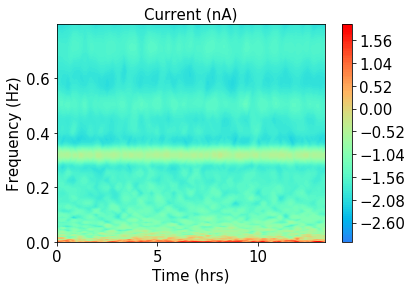

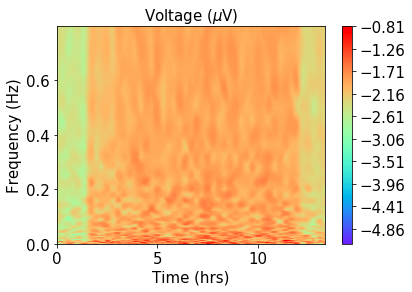

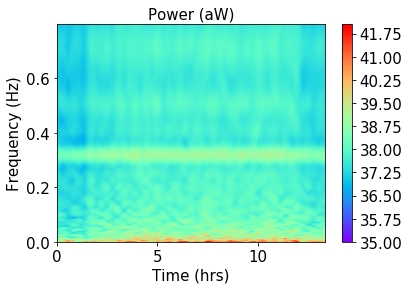

In [69]:
# PLOT IN FREQUENCY DOMAIN OVER TIME
tmatflat = np.array([]) #make flat array of repeating "times"
for i in range(len(fmat)): tmatflat = np.append(tmatflat, np.ones(len(fmat[0]))*i*1000/60/60)

fmatflat = fmat.flatten(); imatflat = imat.flatten()
vmatflat = vmat.flatten(); pmatflat = pmat.flatten()

Zlist = [imatflat, vmatflat, pmatflat] #list of Z values in heatmaps
heatmaplabels = ['Current (nA)', 'Voltage ($\mu$V)', 'Power (aW)']


for i in range(len(Zlist)):  # plot heatmaps of time/frequency-dependent noise
    # set X, Y, and Z for plot
    X, Y, Z, = tmatflat, fmatflat, np.log(Zlist[i]) #np.log10(fmatflat), np.log10(Zlist[i]) #time, frequency, noise

    # create x-y points to be used in heatmap
    xi = np.linspace(X.min(),X.max(),1000)
    yi = np.linspace(Y.min(),Y.max(),1000)
    # Z is a matrix of x-y values
    zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

    # Create the contour plot
    CS = plt.contourf(xi, yi, zi, 150, cmap=plt.cm.rainbow, vmax=np.nanmax(Z), vmin=np.nanmin(Z))
    plt.colorbar(); plt.xlabel('Time (hrs)',fontsize=15); plt.ylabel('Frequency (Hz)',fontsize=15);
    plt.title(heatmaplabels[i],fontsize=15); plt.show()

In [70]:
# EXTRACT TIME-DOMAIN DATA ##########################################################################################
tskip = 3202
tdata = pd.read_csv(noisefile, skiprows=tskip, header=0, error_bad_lines=False, sep='\s+') #read in file
####################################################################################################################
tfloatdata = tdata.apply(pd.to_numeric, errors='coerce') #change from string to float, coercing to NaN 
print(tfloatdata)

        volt.noise/V  curr.noise/A
0      -5.442000e-07 -1.584000e-09
1       1.471000e-05  2.855000e-09
2      -5.442000e-07  3.435000e-09
3      -5.442000e-07  5.741000e-09
4      -5.442000e-07 -9.183000e-09
5      -5.442000e-07  5.939000e-09
6      -5.442000e-07  2.230000e-09
7      -5.442000e-07  1.102000e-08
8      -5.442000e-07  5.146000e-09
9      -5.442000e-07  5.327000e-09
10     -5.442000e-07  5.862000e-09
11     -5.442000e-07 -1.288000e-08
12     -5.442000e-07 -3.187000e-09
13     -5.442000e-07 -6.984000e-10
14     -5.442000e-07  1.467000e-09
15     -5.442000e-07  2.337000e-09
16     -5.442000e-07  6.046000e-09
17     -5.442000e-07 -1.509000e-09
18     -5.442000e-07 -4.315000e-09
19     -5.442000e-07  1.757000e-09
20     -5.442000e-07  1.529000e-09
21     -5.442000e-07  9.356000e-09
22     -5.442000e-07 -3.279000e-09
23     -5.442000e-07 -6.131000e-09
24     -5.442000e-07 -6.421000e-09
25     -5.442000e-07  5.389000e-09
26     -5.442000e-07  3.334000e-11
27      1.471000e-05

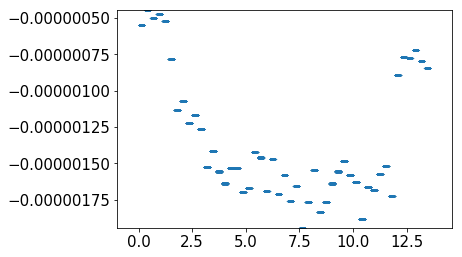

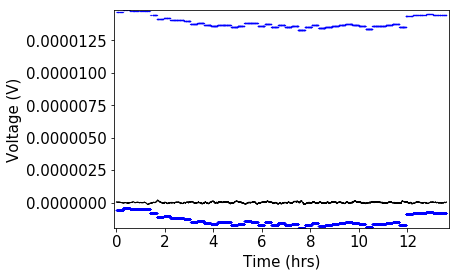

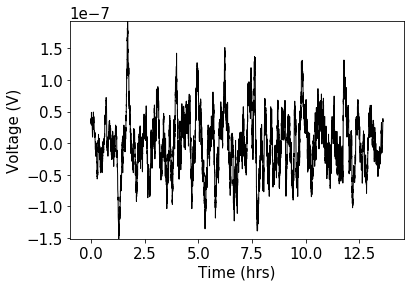

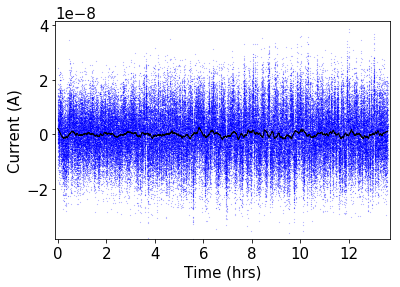

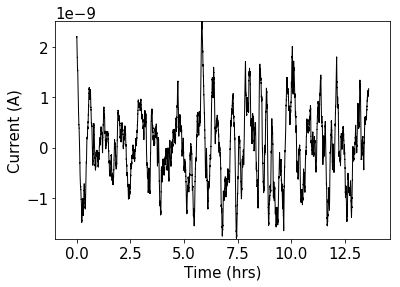

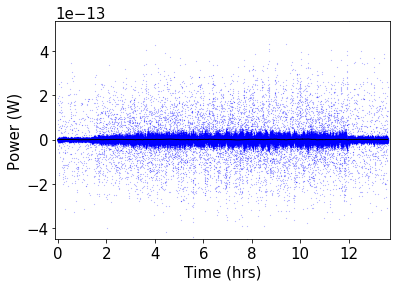

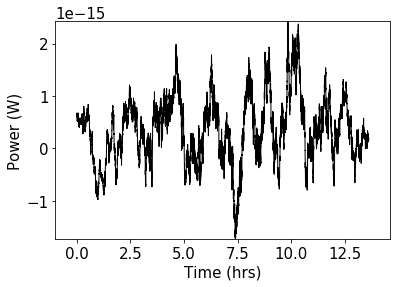

In [82]:
#ORGANIZE AND FILTER/SMOOTH TIME-DOMAIN DATA
from scipy import signal

vt = np.array(tfloatdata['volt.noise/V']) #create voltage nad current arrays for time-domain data 
it = np.array(tfloatdata['curr.noise/A'])
pt = np.multiply(vt,it) #calculate power noise

tlong = (np.arange(len(vt))*0.488)/60/60 #create time array in hours

############### Filter signals to smooth them ####################################
filtwindow = 3001 # number of points to use for filtering
filtorder = 1 #polynomial order ot use for filtering
filtmode = 'constant' #'mirror', 'constant', 'wrap', 'nearest' #mode for dealing with boundary conditions

cval = []; cval_filling = [vt, it, pt]; padpoints = 100 # number of points to use for pad average
for i in range(len(cval_filling)): #average first and last 100 point values to be constants for padding filter 
    cval.append(np.mean((cval_filling[i][si:si+padpoints]) +
                        np.mean(cval_filling[i][-ei-padpoints:-ei]))/2)

vtfilt = savgol_filter(vt, filtwindow, filtorder, mode=filtmode, cval=cval[0])
itfilt = savgol_filter(it, filtwindow, filtorder, mode=filtmode, cval=cval[1])
ptfilt = savgol_filter(pt, filtwindow, filtorder, mode=filtmode, cval=cval[2])

##################################################################################
tvars = [vt, it, pt, np.divide(vt,it)] #create lists for looping
tfiltvars = [vtfilt, itfilt, ptfilt]
tlabels = ['Voltage (V)', 'Current (A)', 'Power (W)']

vshort0 = np.array([]); tshort0 = np.array([])
for i in range(len(vt)):
    if vt[i] < 0:
        vshort0 = np.append(vshort0, vt[i])
        tshort0 = np.append(tshort0, tlong[i])
    else: pass
plt.scatter(tshort0,vshort0, s=.01)
plt.axis((min(tshort0)-1,max(tshort0)+1,min(vshort0), max(vshort0)))
plt.show()

for i in range(len(tfiltvars)): #plot noise with smoothed curves
    plt.plot(tlong, tfiltvars[i],linewidth=1, c='k') #plot filtered/smoothed data
    plt.scatter(tlong, tvars[i], s=.01, c='b') #plot raw data
    plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel(tlabels[i], fontsize=15)
    plt.axis((min(tlong)-.1,max(tlong)+.1,min(tvars[i]), max(tvars[i])))
    plt.show()
    
    plt.plot(tlong, tfiltvars[i],linewidth=1, c='k') #plot ONLY filtered/smoothed data
    plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel(tlabels[i], fontsize=15)
    plt.axis((min(tlong)-1,max(tlong)+1,min(tfiltvars[i]), max(tfiltvars[i])))
    plt.show()

In [77]:
vshort0

array([  3.71015828e-08,   3.68970378e-08,   3.66924928e-08, ...,
         3.49853952e-08,   3.52892071e-08,   3.55927191e-08])

In [24]:
# IMPORT PRESSURE DATA
pressurefile = 'C:\\Users\\a6q\\Desktop\\CorrEL noise measurements\\2017-09-05 ta wire noise h2o steps'
pressuredata = pd.read_csv(pressurefile, delimiter = '\t')# skiprows=fline1, header=0, error_bad_lines=False, sep='\s+') #read in file
#fdata = fdata0.apply(pd.to_numeric, errors='coerce').dropna() #change from string to float, coercing to NaN 
print(pressuredata)

                    date_time  elapsed_time_min  J-KEM_temp_C  \
0      2017-09-05 18:00:19.22        101.494155          26.2   
1      2017-09-05 18:00:22.22        101.544158          26.2   
2      2017-09-05 18:00:25.23        101.594161          26.2   
3      2017-09-05 18:00:28.22        101.644147          26.2   
4      2017-09-05 18:00:31.22        101.694150          26.2   
5      2017-09-05 18:00:34.22        101.744153          26.2   
6      2017-09-05 18:00:37.22        101.794156          26.2   
7      2017-09-05 18:00:40.23        101.844158          26.2   
8      2017-09-05 18:00:43.23        101.894161          26.2   
9      2017-09-05 18:00:46.22        101.944148          26.2   
10     2017-09-05 18:00:49.22        101.994150          26.2   
11     2017-09-05 18:00:52.22        102.044153          26.2   
12     2017-09-05 18:00:55.22        102.094156          26.2   
13     2017-09-05 18:00:58.23        102.144159          26.2   
14     2017-09-05 18:01:0

[16202 rows x 23 columns]


min/max noise times = 0.0 - 13.603135555555555
min/max pressure times = 0.0 - 13.500833316666666
min/max compressed noise times = 0.0004066666666666666 - 13.602728888888889
# of noise time points = 100352
# of pressure time points = 16202; # of compressed noise points = 16202


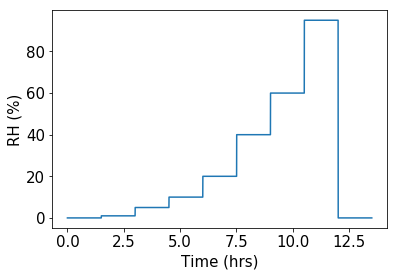

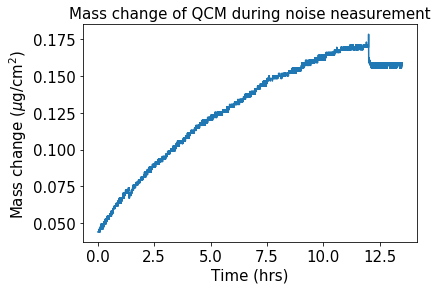

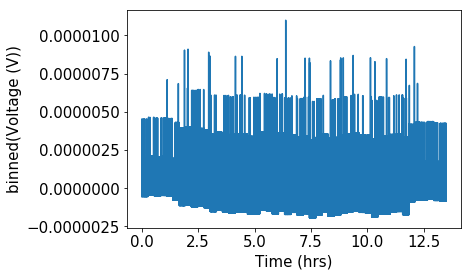

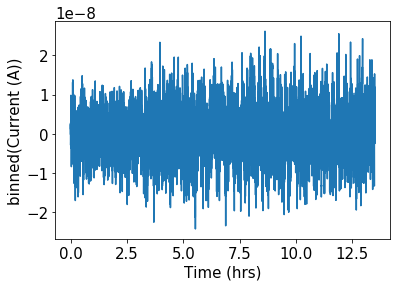

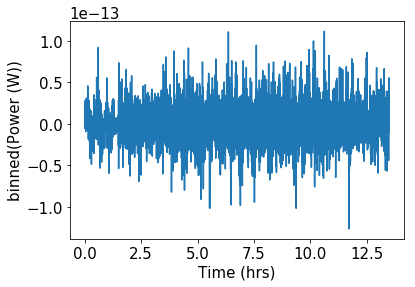

In [25]:
#  MATCH UP NOISE DATA WITH PRESSURE DATA
from scipy import stats

ptime = np.array(pressuredata['elapsed_time_min'] - min(pressuredata['elapsed_time_min']))/60 #pressure times
rh = np.array(pressuredata['pressure_setpoint_Torr']) #pressures (or RH)

#compress each variable to length of pressure data by taking statistics of bins
tmatch = stats.binned_statistic(tlong, tlong, statistic='median', bins=len(ptime))[0] 
vmatch = stats.binned_statistic(tlong, vtfilt, statistic='median', bins=len(ptime))[0]
imatch = stats.binned_statistic(tlong, itfilt, statistic='median', bins=len(ptime))[0]
pmatch = stats.binned_statistic(tlong, ptfilt, statistic='median', bins=len(ptime))[0]

print('min/max noise times = ' + format(min(tlong)) + ' - ' + format(max(tlong)))
print('min/max pressure times = ' + format(min(ptime)) + ' - ' + format(max(ptime)))
print('min/max compressed noise times = ' + format(min(tmatch)) + ' - ' + format(max(tmatch)))
print('# of noise time points = ' + format(len(tlong)))
print('# of pressure time points = ' + format(len(ptime)) + '; # of compressed noise points = ' + format(len(tmatch)))

plt.plot(ptime,rh); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('RH (%)', fontsize=15);
plt.show() #plot pressure / RH

plt.plot(ptime, pressuredata.iloc[:,6]) #plot QCM response during noise measurement
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('Mass change ($\mu$g/cm$^2$)', fontsize=15)
plt.title('Mass change of QCM during noise neasurement', fontsize=15); plt.show()

plt.plot(ptime,vmatch); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('binned(Voltage (V))', fontsize=15); plt.show()
plt.plot(ptime,imatch); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('binned(Current (A))', fontsize=15); plt.show()
plt.plot(ptime,pmatch); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('binned(Power (W))', fontsize=15); plt.show()

training time (min) =  0.963 , testing MSE (%) =  4116.194
average absolute error (%) =  36.736


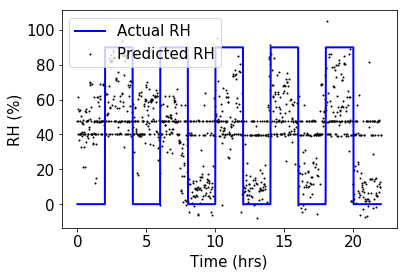

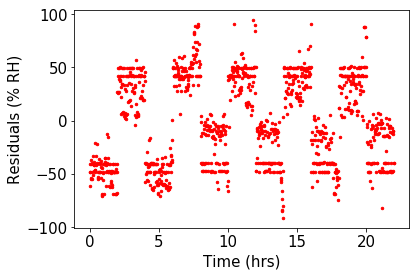

In [48]:
# USE NEURAL NET REGRESSOR TO PREDICT PRESSURE USING NOISE DATA
NNstarttime = timer() #start timer to monitor training time

NNpnts = 1000 #len(vmatch) #number of points to sample for ANN analysis
ptime_short = ptime[::int(len(vmatch)/NNpnts)] #slice to reduce number of data points
vmatch_short = vmatch[::int(len(vmatch)/NNpnts)] 
imatch_short = imatch[::int(len(imatch)/NNpnts)]
pmatch_short = pmatch[::int(len(pmatch)/NNpnts)]
rh_short = rh[::int(len(rh)/NNpnts)]

############## standardize data by subtracting mean and dividing by st. dev. ###########
vmatch_st = np.divide(np.subtract(vmatch_short,np.mean(vmatch_short)),np.std(vmatch_short))
imatch_st = np.divide(np.subtract(imatch_short,np.mean(imatch_short)),np.std(imatch_short))
pmatch_st = np.divide(np.subtract(pmatch_short,np.mean(pmatch_short)),np.std(pmatch_short))
rh_st = np.divide(np.subtract(rh_short,np.mean(rh_short)),np.std(rh_short))

inputlist = (vmatch_st, imatch_st)# insert data to be used as columns for input matrix
targetlist = (rh_st) #insert data to be used as columns for target matrix

#create input matrix and target matrix for feeding into ANN
inputmatrix = np.array(inputlist).T if len(np.shape(inputlist)) > 1 else np.array(inputlist) 
targetmatrix = np.array(targetlist).T if len(np.shape(targetlist)) > 1 else np.array(targetlist)
targetmatrix = targetmatrix.reshape(-1,1)

actual = np.array([]); prediction = np.array([]) #empty arrays for appending ANN results at each k-fold
errors_raw = np.array([]); tar_times = np.array([])

nn = Regressor(layers=[
        Layer('Sigmoid', units=14), # design network with hidden layers
        Layer('Sigmoid', units=5),
        Layer('Sigmoid', units=2),
        Layer('Linear')], #output layer
    learning_rate=0.02, n_iter=1000)
kf = KFold(n_splits=5, shuffle=True) # k-fold validation for ANN testing

for train_index, test_index in kf.split(inputmatrix): #split into k test/train sets and loop oever each one
    inp_train, inp_test = inputmatrix[train_index], inputmatrix[test_index]
    tar_train, tar_test = targetmatrix[train_index], targetmatrix[test_index]

    nn.fit(inp_train, tar_train) #train network
    prediction_raw = nn.predict(inp_test) #make predictions (still standardized)

    prediction0 = np.add(np.multiply(np.std(rh_short),prediction_raw),np.mean(rh_short)) #unstandardize prediction
    actual0 = np.add(np.multiply(np.std(rh_short),tar_test),np.mean(rh_short)) #unstandardize actual target
    prediction = np.append(prediction, prediction0) #build predictions
    actual = np.append(actual, actual0) #build actual targets
    errors_raw = np.append(errors_raw, np.subtract(actual0, prediction0)) #calculate prediction errors
    tar_times = np.append(tar_times, ptime_short[test_index]) #make array of times that correspond to testing points

    #print(nn.get_parameters()) #summarize network parameters

NNendtime = timer(); NNtime = (NNendtime - NNstarttime) / 60 #total training time in minutes
print('training time (min) = ', round(NNtime,3), ', testing MSE (%) = ', round(MSE(actual, prediction),3))
print('average absolute error (%) = ', round(np.mean(np.abs(errors_raw)),3))

plt.plot(ptime_short, rh_short, c='b', linewidth=2, label='Actual RH') #plot pressure / RH
plt.scatter(tar_times, prediction, c='k', s=1, label='Predicted RH') #plot predictions
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('RH (%)', fontsize=15)
plt.legend(loc='upper left', fontsize=15); plt.show()

plt.scatter(tar_times, errors_raw, c='r', s=6) #plot errors
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('Residuals (% RH)', fontsize=15)
plt.show()

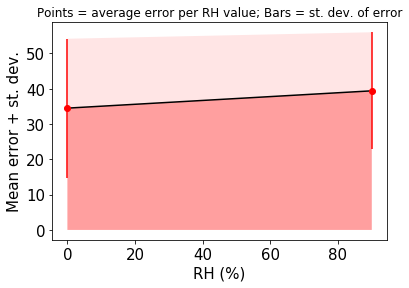

RH values =  [  0.  90.]
avg errors =  [ 34.5  39.4]
error st. dev. =  [ 19.66  16.59]


In [49]:
# Analyze ANN errors
rhvalues = np.unique(actual)
errormean, errorstd = np.array([]), np.array([])
for i in rhvalues: #look through each individual RH value
    error00 = np.array([])
    for j in range(len(errors_raw)): #collect errors at each RH to average them as a function of RH
        if i == actual[j]: error00 = np.append(error00, errors_raw[j]) 
    errormean = np.append(errormean, np.mean(np.abs(error00)))
    errorstd = np.append(errorstd, np.std(np.abs((error00))))

plt.errorbar(rhvalues, errormean, yerr=errorstd, fmt='o', c='r')
plt.plot(rhvalues, errormean, c='k')
plt.fill_between(rhvalues, 0, errormean+errorstd, facecolor='red', alpha=.1, interpolate=True)
plt.fill_between(rhvalues, 0, errormean, facecolor='red', alpha=.3, interpolate=True)


plt.xlabel('RH (%)', fontsize=15); plt.ylabel('Mean error + st. dev.', fontsize=15)
plt.title('Points = average error per RH value; Bars = st. dev. of error')
plt.show()

print('RH values = ', rhvalues)
print('avg errors = ', np.around(errormean, decimals=2))
print('error st. dev. = ', np.around(errorstd, decimals=2))

In [26]:
len(vmatch_st)
#%store errormean

5746

# SAVE NN RESULTS TO CSV FILE

NNfile = "NNresults.csv"
saveNNdata = []; NNheaders = []; savetar = []

#see if input/target lists are multi-dimensional and reshape if necessary
#save test inputs:
if len(np.shape(inputlist)) > 1:
    for i in range(len(inputlist)):
        saveNNdata.append(zip(*inp_test)[i])
        NNheaders.append('test_input' + str(i+1))
else:
    saveNNdata.append(np.reshape(inp_test,len(inp_test)))
    NNheaders.append('test_input')
    
#save test targets and predictions:
if len(np.shape(targetlist)) > 1:
    for i in range(len(targetlist)):
        saveNNdata.append(zip(*tar_test)[i]) 
        NNheaders.append('test_target' + str(i+1))
        saveNNdata.append(zip(*prediction)[i])
        NNheaders.append('prediction' + str(i+1))
else:
    saveNNdata.append(np.reshape(tar_test,len(tar_test)))
    NNheaders.append('test_target')
    saveNNdata.append(np.reshape(prediction, len(tar_test)))
    NNheaders.append('prediction')
                        
saveNNdata = zip(*saveNNdata)
#open CSV file
with open(NNfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(NNheaders) #write headers
    for row in saveNNdata:
        writer.writerow(row)

#grid search optimizes network among the choices you give it:
'''
gs = GridSearchCV(nn, param_grid={
    'learning_rate': [0.05, 0.01, 0.005, 0.001],
    'hidden0__units': [4,8,12]
    'hidden0__type': ['Rectifier', 'Sigmoid', 'Tanh']})
gs.fit(X,y)
'''
# or among random parameters:
'''
gs = RandomizedSearchCV(nn, param_distributions={
    'learning_rate': stats.uniform[0.001, 0.1],
    'hidden0__units': stats.radint[3,15],
    'hidden0__type': ['Rectifier', 'Sigmoid', 'Tanh']})
gs.fit(X,y)
'''
#to save trained network:
#pickle.dump(nn, open('nn.pk1', 'wb'))

#to load trained network:
# nn = pickel.load(open('nn.pk1', 'rb'))

